#  Al–Al<sub>2</sub>O<sub>3</sub> Bicrystal Demo

This notebook walks through a use case of getting a feasible bicrystal structure for a HAADF STEM image of a Al–Al<sub>2</sub>O<sub>3</sub> (111)-(001) grain boundary. 

It is assumed that you have an MP API key set as your "MAPI_KEY" environment variable. If not, be sure to paste in your API key as a string argument to the MPRester() call in [<code>structure.py</code>](https://github.com/eschwenk/ingrained/blob/master/ingrained/structure.py)

In [1]:
import os
import cv2
import dm3_lib as dm3lib
import matplotlib.pyplot as plt

# Main ingrained package modules
from ingrained.structure import Bicrystal
from ingrained.optimize import CongruityBuilder

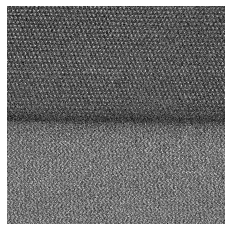

In [2]:
# Set path to dm3 microscopy image
dm3_path = "dm3/39.dm3"

# An optional way to view experimental image
plt.imshow(dm3lib.DM3(dm3_path).imagedata, cmap='gray'); plt.axis('off');

__NOTE:__  Viewing geometry conventions
<img src="https://drive.google.com/uc?export=view&id=18gbztawspAF1_6caacGiTxpcEKgIehcD" width="210">

In [3]:
# Input chemistry and orientation information for each grain separately
# NOTE: initial letter of a space group symbol 
#    - primitive (P)
#    - single-face centred (A, B, or C)
#    - all-face centred (F)
#    - body-centred (I)
#    - rhomohedrally centred (R)

# For top grain
grain_1 = {}
grain_1["chemical_formula"]     = "Al"
grain_1["space_group"]          = "Fm-3m"   # space group (min volume)
grain_1["uvw_project"]          = [0,1,-1]  # u,v,w, direction from screen to viewer
grain_1["uvw_upward"]           = [1,1,1]   # upward u,v,w direction on the screen
grain_1["tilt_angle"]           = 0         # angle (CCW) around "uvw_project"
grain_1["max_dimension"]        = 30        # maximum bicrystal dimension (Å)

# For bottom grain
grain_2 = {}
grain_2["chemical_formula"]     = "Al2O3"
grain_2["space_group"]          = "R-3c"    # space group (min volume)
grain_2["uvw_project"]          = [2,1,0]   # u,v,w, direction from screen to viewer
grain_2["uvw_upward"]           = [0,0,1]   # upward u,v,w direction on the screen
grain_2["tilt_angle"]           = 0         # angle (CCW) around "uvw_project"
grain_2["max_dimension"]        = 30        # maximum bicrystal dimension (Å)

In [4]:
# Initialize a Bicrystal from a list of grain dictionaries, specifying min/max width and depth (Å) 
bicrystal = Bicrystal([grain_1,grain_2], minmax_width=(10,40), minmax_depth=(8,20))

# Or load an existing bicrystal structure
# bicrystal = Bicrystal(os.getcwd()+"/structures/039.POSCAR.vasp")

In [5]:
# Setup optimization to parameterize fit between simulation and experiment

# Use the pixel scaling information from the dm3 and define reasonable SOFT constraints on parameter values
if dm3lib.DM3(dm3_path).pxsize[1].decode('UTF-8') == 'nm':
    pixsz = dm3lib.DM3(dm3_path).pxsize[0]*10
    
# Constraints 
iw = [-1,2.5]                 # range of interface widths (Å)
df = [0.75,1.75]              # range of defocus values (Å)
px = [0.85*pixsz,1.15*pixsz]  # range of allowable pixel sizes (Å)
bx = [0.0,0.15]               # range of x-border reduction ratio (vertical) 
by = [0.0,0.15]               # range of y-border reduction ratio (horizontal)

In [6]:
# Initialize a ConguityBuilder to optimize a the fit between a HAADF simulation of the bicrystal and the experiment
congruity = CongruityBuilder(bicrystal=bicrystal,dm3=dm3_path)

# Define a starting point for optimization 
#    | iw | df | bx | by | px |
x0 = [-0.1, 1.3, 0, 0.1, pixsz]

In [7]:
# Perform *constrained* minimization using a COBYLA solver

# res1 = congruity.find_correspondence(optimizer='COBYLA', initial_solution=x0, constraint_list=[iw,df,bx,by,px])

###### Can take several minutes to run...

Summary of the output:
```
Starting Solution: (already pretty good!)
>>> IW : -0.1
>>> DF : 1.3
>>> PX : 0.11601458303630352
>>> BX : 0.0
>>> BY : 0.1
Warning: Proceed with caution! (SHIFT ERROR: 14)
🌀 FOM : 2.3706925337407956 
.
.
.

Early Solution: 
>>> IW : 0.17573019844487398
>>> DF : 1.2642634487286104
>>> PX : 0.13341703685680034
>>> BX : 0.030972566154944224
>>> BY : 0.13080748550300453
🌀 FOM : 0.9344864720140797
.
.
.
 
Final Solution: 
Current Solution: 
>>> IW : 0.15471137641040433
>>> DF : 1.2600068578982349
>>> PX : 0.13322222916909848
>>> BX : 0.035660941995556354
>>> BY : 0.1365686390944503
🌀 FOM : 0.9036142846278795

     fun: 0.9036142846278795
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 80
  status: 1
 success: True
       x: array([0.15471138, 1.26000686, 0.03566094, 0.13656864, 0.13322223])
```  

In [8]:
# Perform *unconstrained* minimization using a POWELL solver for further refine the solution from the previous step.
# NOTE: Takes sequential one-dimensional minimizations, 
#       so convergence can be quite slow. In addition, 
#       there is no check in place to assure that SOFT 
#       constraints are upheld. Violation of any HARD 
#       constraints defined inside the Bicrystal and
#       ConguityBuilder classes will throw an arbitrarily 
#       large '9999' FOM value.

# res2 = congruity.find_correspondence(optimizer='Powell', initial_solution=res1.x)

Can take several more minutes to run...

Summary of the output:
```
Initial Solution: 
>>> IW : 0.15471137641040433
>>> DF : 1.2600068578982349
>>> PX : 0.13322222916909848
>>> BX : 0.035660941995556354
>>> BY : 0.1365686390944503
🌀 FOM : 0.9036142846278795
.
.
.

Final Solution: 
>>> IW : 0.111786813217729
>>> DF : 1.1488391624705199
>>> PX : 0.13293286291986323
>>> BX : 0.19202984629506112
>>> BY : 0.1349849784503173
🌀 FOM : 0.8830118873221758

Optimization terminated successfully.
         Current function value: 0.883012
         Iterations: 5
         Function evaluations: 1043
 
```

In [9]:
IW = 0.111786813217729
DF = 1.1488391624705199
PX = 0.13293286291986323
BX = 0.19202984629506112
BY = 0.1349849784503173

# With the final parameterization, write the cropped experimental image 'fitted' to HAADF simulation to file
congruity.fit(interface_width=IW, defocus=DF, border_reduce=(BX,BY), pixel_size=PX, save_simulation = "images/Al-Al2O3_gb_sim.jpg", save_experiment = "images/Al-Al2O3_gb_exp.jpg")

# To write the bicrystal with the apppropriate interface width to file:
bicrystal.to_vasp(os.getcwd()+"/structures/Al-Al2O3_gb_init",interface_width=IW)

In [10]:
# To use final solution with 'fitted' experimental patch for future simulation & comparison,
# load current structure as a Bicrystal and simulate a HAADF image with the new parameters

# NOTE: If no "pixel_size" specified, simulation will 
#       automatically use pixel size defined in the dm3.

# NOTE: If using a structure where the interface has 
#       already been optimized, leave this parameter blank!

bicrystal = Bicrystal(os.getcwd()+"/structures/Al-Al2O3_gb_init.POSCAR.vasp");
bicrystal.convolution_HAADF(filename="images/Al-Al2O3_gb_test.jpg", dm3=dm3_path, pixel_size=PX, defocus=DF, border_reduce=(BX,BY));

#### Al–Al<sub>2</sub>O<sub>3</sub> Bicrystal Structure: 

<img src='https://drive.google.com/uc?export=view&id=1GLyn2DGU162l3URi3SGCQvF09QL-UcHy' width="175">

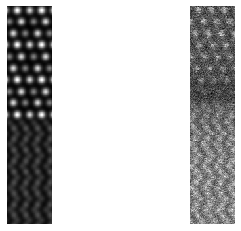

In [11]:
# View simulation and matching experimental patch
f, axarr = plt.subplots(1,2);

axarr[0].imshow(cv2.imread(os.getcwd()+"/images/Al-Al2O3_gb_sim.jpg",0), cmap='gray');
axarr[0].axis('off');

axarr[1].imshow(cv2.imread(os.getcwd()+"/images/Al-Al2O3_gb_exp.jpg",0), cmap='gray');
axarr[1].axis('off');